 Содание модели, предсказывающей буквы латинского алфавита на основе базы EMNIST.

1. Предобработка базы изображений (удаление неинформативных пикселей, уменьшение значений в пределах 0...1, нормализация с помощью StandardScaler)
2. Поиск наиболее подходящего классификатора
3. Подбор наиболее подходящих гиперпараметров нескольких наилучших классификаторов
4. Получение результатов на тестовой выборке
5. Попытка снизить размерность модели с помощью PCA.
6. Отдельная попытка, неудачная: векторизация изображений https://colab.research.google.com/drive/13sTcHhWMHVAnNm5XqxOj9V-SITQ7ERZo?usp=sharing В итоге потом вернулся к работе над данным ноутбуком

P.S. Ячеек мало, так как многие неудачные эксперименты почистил. Отчет в последней ячейке.

### Подготовка среды

In [ ]:
!pip install -U kaggle scikit-learn==1.0 scikit-image

In [ ]:
!touch /content/kaggle.json
!chmod 600 /content/kaggle.json

In [ ]:
import json
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
api_token = {'username': 'rafaelkamashev', 'key': 'e6891d0b2b04d3bd70bcc194f6157081'}

with open('/content/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [ ]:
!kaggle competitions download -c jds3 --force

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import json
import os
import string
import warnings

from skimage.filters import threshold_otsu
from skimage.morphology import closing, square
from skimage.morphology import skeletonize
from skimage.transform import probabilistic_hough_line
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier,
    HistGradientBoostingClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
)
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection._search_successive_halving import HalvingGridSearchCV
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


warnings.filterwarnings('ignore')

%matplotlib inline
'imported'

'imported'

### Подготовка данных

In [2]:
test_df = pd.read_csv('jds3/emnist-letters-test-sh.csv', header=None).values
test_df.shape

(14800, 784)

In [3]:
%%time
train_df = pd.read_csv('jds3/emnist-letters-train.csv.zip', header=None)
train_df.shape

CPU times: user 3.56 s, sys: 240 ms, total: 3.8 s
Wall time: 3.8 s


(88800, 785)

In [4]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y, X = train_df[0].values, train_df.drop(0, axis=1)
X.rename(columns={col + 1: col for col in (X.columns - 1)}, inplace=True)
(y.shape, X.shape)

((88800,), (88800, 784))

In [5]:
alphabet = list(string.ascii_lowercase)
string.ascii_lowercase

'abcdefghijklmnopqrstuvwxyz'

Y =  u


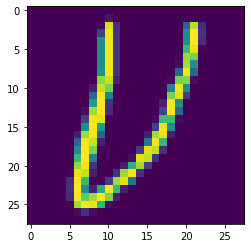

In [6]:
idx = np.random.randint(0, X.shape[0])
print('Y = ', alphabet[y[idx] - 1])
plt.imshow(X.loc[idx].values.reshape(28, 28).T)

In [7]:
def remove_pixels(df):
  """
  Функция убирает неинформативные пиксели, в которых не было ни одного значения во всех примерах,
  либо такое значение было на максимуме
  """

  changed_df = df.loc[:]
  dropped_px = []

  for col in df:
    if changed_df[col].max() <= 0 or changed_df[col].min() >= 255:
      changed_df.drop(columns=[col], inplace=True)
      dropped_px.append(col)
  
  return changed_df, dropped_px

In [8]:
%%time
new_train_df, dropped = remove_pixels(X)
new_train_df.shape

CPU times: user 2.26 s, sys: 2.18 s, total: 4.44 s
Wall time: 4.44 s


(88800, 737)

In [9]:
X_train = new_train_df.values
# следующее напрасно: потеря информации, уменьшение качества предсказания на 3-5%
# Возможно отсекать нужно жестче, учитывая, что в MNIST не шумов
# на мой взгляд, лучше уменьшить размерность в 255 раз и обработать через StandardScaler
# X_train[X_train < 128] = 0
# X_train[X_train >= 128] = 255

# приводим к размерности .0 ... .1
X_train = X_train / 255.
X_train.shape

(88800, 737)

In [10]:
%%time

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
print(X_train_scaled.shape)

vectorizer = TfidfTransformer()
X_train_tf_idf = vectorizer.fit_transform(X_train)
X_train_tf_idf.shape

(88800, 737)
CPU times: user 2.86 s, sys: 298 ms, total: 3.16 s
Wall time: 3.15 s


(88800, 737)

In [11]:
# # убираем колонки пикселей в тестовой, которые удалили из тренировочной выборки
X_test_dropped = np.delete(test_df, dropped, 1)
print(X_test_dropped.shape)

# также аналогично с тренировочной выборкой нормализуем
X_test_scaled = X_test_dropped / 255.
X_test_scaled = sc.transform(X_test_scaled)

(14800, 737)


### Предварительная оценка эффективности

In [13]:
batch = 20000
# берем 20 тыс. из тренировочной выборки для предварительной проверки гипотез
X_train_small, X_train_scaled_small, y_train_small = X_train[:batch], X_train_scaled[:batch], y[:batch]
X_train_scaled_small.shape

(20000, 737)

In [ ]:
folds = 10
random_state = 10
verbose = 1  # 0

# закомментрированные показали слишком низкий результат при первых попытках.
# Одиночные модели SVC, KNeighbors тоже проверял по многу раз, пробую ансамблевые

#     'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=8),
#     'LogisticRegression': LogisticRegression(multi_class='multinomial'),
#     'BernoulliNB': BernoulliNB(),
#     'AdaBoostDT': AdaBoostClassifier(
#         DecisionTreeClassifier(max_depth=8, min_samples_split=4, random_state=random_state),
#         n_estimators=50, random_state=random_state
#     ),
#     'BaggingDT': BaggingClassifier(
#         DecisionTreeClassifier(max_depth=8, min_samples_split=4, random_state=random_state),
#         n_estimators=10, random_state=random_state, verbose=verbose
#     ),
#     'GradientBoosting': GradientBoostingClassifier(
#         min_samples_split=4, n_estimators=50, random_state=random_state, verbose=verbose
#     ),

models = {
    'ExtraTrees': ExtraTreesClassifier(
        max_depth=10, min_samples_split=5, n_estimators=100, random_state=random_state, verbose=verbose
    ),
    'HistGradientBoosting': HistGradientBoostingClassifier(random_state=random_state, verbose=verbose),
    'BaggingKN': BaggingClassifier(
        KNeighborsClassifier(n_neighbors=10),
        n_estimators=100, random_state=random_state, verbose=verbose
    ),
    'BaggingSVC': BaggingClassifier(
        SVC(C=1.2, gamma=.5, kernel='rbf', random_state=random_state, cache_size=1024),
        n_estimators=10, random_state=random_state, verbose=verbose
    )
}

results = {}

for name, model in models.items():
  print(name, '... ')
  k_fold = KFold(n_splits=folds)
  res = cross_val_score(
      model, X_train_scaled_small, y_train_small, cv=k_fold, scoring='accuracy', n_jobs=-1, verbose=verbose
  )
  print(name, res, res.mean())
  results[name] = res.mean()

Не дотерпел. Запускать на слабом ноутбуке 10 классификаторов SVC параллельно с беггингом было ошибкой. Скопирую лог показателей точности кросс-валидации:
```
GradientBoosting [0.697  0.7065 0.695  0.719  0.714  0.71   0.7005 0.704  0.7225 0.7145] 0.7083
BaggingKN [0.7415 0.7515 0.7465 0.7555 0.7535 0.7515 0.732  0.759  0.768  0.762 ] 0.75209
BaggingDT [0.639  0.638  0.629  0.656  0.6385 0.64   0.627  0.6235 0.645  0.654 ] 0.639
AdaBoostDT [0.528  0.5105 0.5305 0.4985 0.547  0.5095 0.5035 0.5085 0.512  0.5165] 0.51645
HistGradientBoosting [0.8215 0.834  0.8265 0.83   0.8245 0.829  0.821  0.826  0.841  0.8435] 0.829699
ExtraTrees [0.7555 0.7605 0.752  0.7675 0.777  0.768  0.7555 0.748  0.77   0.7715] 0.762549
```

In [27]:
# выберем лучшие гиперпараметры
random_state = 10
verbose = 1
clfs = {
    'extra_trees': {
        'clf': ExtraTreesClassifier(random_state=random_state, verbose=0, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200, 300, 400],
            'criterion': ['gini', 'entropy'],
            'max_depth': [5, 8, 10, 15, 25],
            'min_samples_split': [3, 5, 10],
            'max_features': ['auto', 'sqrt', 'log2']
        }
        
    },
# выполнялся крайне долго. Решил подобрать параметры вручную
#     'hist_gradient_boosting': {
#         'clf': HistGradientBoostingClassifier(random_state=random_state, verbose=0),
#         'params': {
#             'l2_regularization': [0., 0.5, 1., 1.5],
#             'max_iter': [1000, 1200, 1500],
#             'max_leaf_nodes': [15, 31, 50],
#             'max_depth': [10, 25, 50, 75],
#             'min_samples_leaf': [5, 15, 30]
#         }
#     }
}

inputs = {
    'scaled_sample': X_train_scaled,
    'tf_idf': X_train_tf_idf
}

grids = {}
for classifier_name, config in clfs.items(): 
    print(f'\n{classifier_name}...')
    clf, params = config['clf'], config['params']

    for input_name, input_ in inputs.items():
        search = HalvingGridSearchCV(
            clf, params, cv=5, factor=2, min_resources=30, n_jobs=-1, verbose=verbose
        ).fit(input_, y)

        grids[(classifier_name, input_name)] = search

        print(
            '!!!!!!',
            'clf=', classifier_name,
            ', input=', input_name,
            ', best_params_', search.best_params_,
            ', best_score_', search.best_score_,
            ', best_estimator_', search.best_estimator_
        )


extra_trees...
n_iterations: 9
n_required_iterations: 9
n_possible_iterations: 12
min_resources_: 30
max_resources_: 88800
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 360
n_resources: 30
Fitting 5 folds for each of 360 candidates, totalling 1800 fits
----------
iter: 1
n_candidates: 180
n_resources: 60
Fitting 5 folds for each of 180 candidates, totalling 900 fits
----------
iter: 2
n_candidates: 90
n_resources: 120
Fitting 5 folds for each of 90 candidates, totalling 450 fits
----------
iter: 3
n_candidates: 45
n_resources: 240
Fitting 5 folds for each of 45 candidates, totalling 225 fits
----------
iter: 4
n_candidates: 23
n_resources: 480
Fitting 5 folds for each of 23 candidates, totalling 115 fits
----------
iter: 5
n_candidates: 12
n_resources: 960
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 6
n_candidates: 6
n_resources: 1920
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 7
n_candidates

KeyboardInterrupt: 

In [12]:
def do_pca(n_components, data):
  """Уменьшение размерности выборки с помощью PCA"""
  pca = PCA(n_components)
  X_pca = pca.fit_transform(data)

  return pca, X_pca


def fit_classifier(X_train, X_test, y_train, y_val, clf=None, classifier=SVC, clf_params=None, print_output=True):
  """Функция трениовки модели и проверки на валидирующей выборке"""
  if clf_params is None:
    clf_params = {}

  if clf is None:
    clf = classifier(n_jobs=-1, **clf_params)
  clf.fit(X_train, y_train)

  y_preds = clf.predict(X_test)
  acc = accuracy_score(y_val, y_preds)

  if print_output == True:
      mat = confusion_matrix(y_val, y_preds)
      sns.heatmap(mat, annot=True, cmap='bwr', linewidths=.5)

      print('Input Shape: {}'.format(X_train.shape))
      print('Accuracy: {:2.2%}\n'.format(acc))
      print(mat)

  return acc, clf

In [14]:
# разбираем тренировочный сет на тренировочный и валидирующий наборы
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y, test_size=.2, random_state=10)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
clf = RandomForestClassifier(
    random_state=random_state, verbose=0, n_jobs=-1,
    n_estimators=400, max_depth=12, min_samples_split=3, min_samples_leaf=5
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'Accuracy', acc)

(71040, 737) (17760, 737) (71040,) (17760,)
Accuracy 0.855518018018018


In [15]:
# валидационный прогон с учетом PCA
n_components = 0.98  # 98%

pca, X_pca = do_pca(n_components, X_train_scaled)
print(f'PCA dimensions std sc: {X_pca.shape}')

PCA dimensions std sc: (88800, 334)


In [19]:
# попробовал PCA, но результат стал хуже. Похоже, PCA лучше работает не в древовидных классификаторах.
# Но они рассчитываются дольше, мне не хватит времени.
X_train, X_val, y_train, y_val = train_test_split(X_pca, y, test_size=.2, random_state=10)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
clf = RandomForestClassifier(
    random_state=random_state, verbose=0, n_jobs=-1,
    n_estimators=400, max_depth=12, min_samples_split=3, min_samples_leaf=5
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'Accuracy', acc)

(71040, 334) (17760, 334) (71040,) (17760,)
Accuracy 0.7596846846846846


In [22]:
# пробую стандартные настройки для градиентного бустинга, основанного на гистограммах
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y, test_size=.2, random_state=10)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
clf = HistGradientBoostingClassifier(
    random_state=10, verbose=1,
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'Accuracy', acc)

(71040, 737) (17760, 737) (71040,) (17760,)
Binning 0.377 GB of training data: 2.358 s
Binning 0.042 GB of validation data: 0.063 s
Fitting gradient boosted rounds:
[1/100] 26 trees, 806 leaves (31 on avg), max depth = 12, train loss: 2.12842, val loss: 2.20265, in 2.813s
[2/100] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 1.81773, val loss: 1.92594, in 2.858s
[3/100] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 1.60329, val loss: 1.73178, in 3.045s
[4/100] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 1.43537, val loss: 1.57852, in 3.104s
[5/100] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 1.29824, val loss: 1.45557, in 3.315s
[6/100] 26 trees, 806 leaves (31 on avg), max depth = 18, train loss: 1.18254, val loss: 1.35199, in 3.259s
[7/100] 26 trees, 806 leaves (31 on avg), max depth = 13, train loss: 1.08569, val loss: 1.26440, in 3.584s
[8/100] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 0.99850, 

[75/100] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 0.06569, val loss: 0.42641, in 3.890s
[76/100] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 0.06391, val loss: 0.42445, in 3.850s
[77/100] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 0.06203, val loss: 0.42346, in 3.921s
[78/100] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 0.06030, val loss: 0.42234, in 3.873s
[79/100] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 0.05863, val loss: 0.42095, in 3.904s
[80/100] 26 trees, 806 leaves (31 on avg), max depth = 14, train loss: 0.05705, val loss: 0.41964, in 3.943s
[81/100] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 0.05547, val loss: 0.41866, in 3.896s
[82/100] 26 trees, 806 leaves (31 on avg), max depth = 20, train loss: 0.05397, val loss: 0.41731, in 3.805s
[83/100] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 0.05251, val loss: 0.41585, in 3.909s
[84/100] 26 trees, 

Красота! Логи очень информативные, тренируется быстро, и начальные настройки довольно оптимальны! Попробую увеличить количество итераций, и потом потренировать через kfold

In [14]:
# лог очень информативен, вижу, что стандартных 100 итераций не хватает для максимизации точности
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y, test_size=.2, random_state=10)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
clf = HistGradientBoostingClassifier(
    random_state=10, verbose=1, max_iter=300
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'Accuracy', acc)

(71040, 737) (17760, 737) (71040,) (17760,)
Binning 0.377 GB of training data: 2.340 s
Binning 0.042 GB of validation data: 0.063 s
Fitting gradient boosted rounds:
[1/300] 26 trees, 806 leaves (31 on avg), max depth = 12, train loss: 2.12842, val loss: 2.20265, in 2.833s
[2/300] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 1.81773, val loss: 1.92594, in 2.872s
[3/300] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 1.60329, val loss: 1.73178, in 3.053s
[4/300] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 1.43537, val loss: 1.57852, in 3.117s
[5/300] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 1.29824, val loss: 1.45557, in 4.295s
[6/300] 26 trees, 806 leaves (31 on avg), max depth = 18, train loss: 1.18254, val loss: 1.35199, in 4.151s
[7/300] 26 trees, 806 leaves (31 on avg), max depth = 13, train loss: 1.08569, val loss: 1.26440, in 3.990s
[8/300] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 0.99850, 

[75/300] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 0.06569, val loss: 0.42641, in 3.894s
[76/300] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 0.06391, val loss: 0.42445, in 3.860s
[77/300] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 0.06203, val loss: 0.42346, in 3.952s
[78/300] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 0.06030, val loss: 0.42234, in 4.142s
[79/300] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 0.05863, val loss: 0.42095, in 3.978s
[80/300] 26 trees, 806 leaves (31 on avg), max depth = 14, train loss: 0.05705, val loss: 0.41964, in 3.938s
[81/300] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 0.05547, val loss: 0.41866, in 3.904s
[82/300] 26 trees, 806 leaves (31 on avg), max depth = 20, train loss: 0.05397, val loss: 0.41731, in 3.823s
[83/300] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 0.05251, val loss: 0.41585, in 3.938s
[84/300] 26 trees, 

[150/300] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 0.01068, val loss: 0.38593, in 4.349s
[151/300] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 0.01047, val loss: 0.38571, in 4.019s
[152/300] 26 trees, 806 leaves (31 on avg), max depth = 18, train loss: 0.01022, val loss: 0.38557, in 4.032s
[153/300] 26 trees, 806 leaves (31 on avg), max depth = 12, train loss: 0.01003, val loss: 0.38547, in 4.155s
[154/300] 26 trees, 806 leaves (31 on avg), max depth = 14, train loss: 0.00983, val loss: 0.38534, in 4.449s
[155/300] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 0.00964, val loss: 0.38543, in 3.931s
[156/300] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 0.00944, val loss: 0.38538, in 4.152s
[157/300] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 0.00924, val loss: 0.38522, in 4.095s
[158/300] 26 trees, 806 leaves (31 on avg), max depth = 14, train loss: 0.00905, val loss: 0.38509, in 4.770s
[159/300] 

In [15]:
y_test_pred = clf.predict(X_test_scaled)
print(y_test_pred.shape, y_test_pred[:10])

submission = pd.DataFrame({'Id': np.arange(1, X_test_scaled.shape[0] + 1), 'Category': y_test_pred})
submission.to_csv(f'jds3/kaggle_mnist_no_pca_hist_grad_b_std_300iter.csv', index=False)

(14800,) [12 14 10 15 12  1  1 18  3 17]


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train_tf_idf.toarray(), y, test_size=.2, random_state=10)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
clf2 = HistGradientBoostingClassifier(
    random_state=10, verbose=1, max_iter=300, validation_fraction=None
)
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'Accuracy', acc)

(71040, 737) (17760, 737) (71040,) (17760,)
Binning 0.377 GB of training data: 3.361 s
Binning 0.042 GB of validation data: 0.067 s
Fitting gradient boosted rounds:
[1/300] 26 trees, 806 leaves (31 on avg), max depth = 12, train loss: 2.15195, val loss: 2.21535, in 2.864s
[2/300] 26 trees, 806 leaves (31 on avg), max depth = 13, train loss: 1.82972, val loss: 1.93546, in 2.900s
[3/300] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 1.60742, val loss: 1.73763, in 3.230s
[4/300] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 1.43606, val loss: 1.58732, in 3.078s
[5/300] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 1.29518, val loss: 1.46210, in 3.525s
[6/300] 26 trees, 806 leaves (31 on avg), max depth = 13, train loss: 1.17999, val loss: 1.35864, in 3.733s
[7/300] 26 trees, 806 leaves (31 on avg), max depth = 13, train loss: 1.08045, val loss: 1.26763, in 3.908s
[8/300] 26 trees, 806 leaves (31 on avg), max depth = 13, train loss: 0.99600, 

[75/300] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 0.06241, val loss: 0.43666, in 4.930s
[76/300] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 0.06069, val loss: 0.43536, in 5.046s
[77/300] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 0.05899, val loss: 0.43434, in 4.673s
[78/300] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 0.05736, val loss: 0.43314, in 3.909s
[79/300] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 0.05579, val loss: 0.43193, in 3.864s
[80/300] 26 trees, 806 leaves (31 on avg), max depth = 19, train loss: 0.05421, val loss: 0.43092, in 6.216s
[81/300] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 0.05275, val loss: 0.42992, in 4.497s
[82/300] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 0.05131, val loss: 0.42891, in 4.115s
[83/300] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 0.04989, val loss: 0.42739, in 4.176s
[84/300] 26 trees, 

[150/300] 26 trees, 806 leaves (31 on avg), max depth = 12, train loss: 0.00997, val loss: 0.39893, in 3.824s
[151/300] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 0.00977, val loss: 0.39897, in 3.857s
[152/300] 26 trees, 806 leaves (31 on avg), max depth = 14, train loss: 0.00955, val loss: 0.39892, in 3.906s
Fit 3952 trees in 641.254 s, (122512 total leaves)
Time spent computing histograms: 423.012s
Time spent finding best splits:  81.205s
Time spent applying splits:      10.416s
Time spent predicting:           0.824s
Accuracy 0.8804054054054054


In [18]:
# с tf_idf стало намного хуже.
# Похоже, такая трансформация должна лучше работать с SVM, регрессиями, но не деревьями.
y_test_pred = clf2.predict(X_test_scaled)
print(y_test_pred.shape, y_test_pred[:10])

submission = pd.DataFrame({'Id': np.arange(1, X_test_scaled.shape[0] + 1), 'Category': y_test_pred})
submission.to_csv(f'jds3/kaggle_mnist_no_pca_hist_grad_b_std_idf_tf_300iter.csv', index=False)

(14800,) [12  9 10 15 12  1  1 18  3  7]


In [19]:
# добавил условие не прекращать перебор, если приблизимся к нужной точности. Результат - стало еще точнее
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y, test_size=.15, random_state=10)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
clf2 = HistGradientBoostingClassifier(
    random_state=10, verbose=1, max_iter=200, n_iter_no_change=20, early_stopping=False
)
clf2.fit(X_train, y_train)
y_pred = clf2.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'Accuracy', acc)

y_test_pred = clf2.predict(X_test_scaled)
print(y_test_pred.shape, y_test_pred[:10])

submission = pd.DataFrame({'Id': np.arange(1, X_test_scaled.shape[0] + 1), 'Category': y_test_pred})
submission.to_csv(f'jds3/kaggle_mnist_no_pca_hist_grad_b_std_idf_tf_200iter.csv', index=False)

(75480, 737) (13320, 737) (75480,) (13320,)
Binning 0.445 GB of training data: 2.768 s
Fitting gradient boosted rounds:
[1/200] 26 trees, 806 leaves (31 on avg), max depth = 13, in 3.048s
[2/200] 26 trees, 806 leaves (31 on avg), max depth = 15, in 3.135s
[3/200] 26 trees, 806 leaves (31 on avg), max depth = 14, in 3.306s
[4/200] 26 trees, 806 leaves (31 on avg), max depth = 16, in 3.412s
[5/200] 26 trees, 806 leaves (31 on avg), max depth = 17, in 3.445s
[6/200] 26 trees, 806 leaves (31 on avg), max depth = 19, in 3.776s
[7/200] 26 trees, 806 leaves (31 on avg), max depth = 15, in 3.884s
[8/200] 26 trees, 806 leaves (31 on avg), max depth = 13, in 3.914s
[9/200] 26 trees, 806 leaves (31 on avg), max depth = 15, in 3.891s
[10/200] 26 trees, 806 leaves (31 on avg), max depth = 19, in 3.982s
[11/200] 26 trees, 806 leaves (31 on avg), max depth = 16, in 4.151s
[12/200] 26 trees, 806 leaves (31 on avg), max depth = 14, in 3.980s
[13/200] 26 trees, 806 leaves (31 on avg), max depth = 17, in

[118/200] 26 trees, 806 leaves (31 on avg), max depth = 14, in 5.408s
[119/200] 26 trees, 806 leaves (31 on avg), max depth = 14, in 4.665s
[120/200] 26 trees, 806 leaves (31 on avg), max depth = 15, in 5.389s
[121/200] 26 trees, 806 leaves (31 on avg), max depth = 15, in 4.714s
[122/200] 26 trees, 806 leaves (31 on avg), max depth = 16, in 5.071s
[123/200] 26 trees, 806 leaves (31 on avg), max depth = 14, in 4.182s
[124/200] 26 trees, 806 leaves (31 on avg), max depth = 16, in 4.882s
[125/200] 26 trees, 806 leaves (31 on avg), max depth = 14, in 5.050s
[126/200] 26 trees, 806 leaves (31 on avg), max depth = 14, in 4.514s
[127/200] 26 trees, 806 leaves (31 on avg), max depth = 14, in 5.921s
[128/200] 26 trees, 806 leaves (31 on avg), max depth = 13, in 4.778s
[129/200] 26 trees, 806 leaves (31 on avg), max depth = 14, in 6.908s
[130/200] 26 trees, 806 leaves (31 on avg), max depth = 16, in 6.358s
[131/200] 26 trees, 806 leaves (31 on avg), max depth = 15, in 5.100s
[132/200] 26 trees, 

In [33]:
# градиентный бустинг, обучаемый через кросс-валидацию k-fold
# 1000 итераций - по 200 в каждом пакете k
clf2 = HistGradientBoostingClassifier(
    random_state=10, verbose=1, max_iter=1000, warm_start=True
)
kf = KFold(n_splits=5)

for k, (train_index, val_index) in enumerate(kf.split(X_train_scaled)):
    print('\nk:', k, "TRAIN:", train_index, "VALIDATION:", val_index)
    X_train, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train, y_val = y[train_index], y[val_index]
    print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

    clf2.fit(X_train, y_train)
    y_pred = clf2.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f'\nAccuracy', acc)


k: 0 TRAIN: [17760 17761 17762 ... 88797 88798 88799] VALIDATION: [    0     1     2 ... 17757 17758 17759]
(71040, 737) (17760, 737) (71040,) (17760,)
Binning 0.377 GB of training data: 2.303 s
Binning 0.042 GB of validation data: 0.064 s
Fitting gradient boosted rounds:
[1/1000] 26 trees, 806 leaves (31 on avg), max depth = 14, train loss: 2.13623, val loss: 2.20052, in 3.917s
[2/1000] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 1.82561, val loss: 1.92874, in 2.910s
[3/1000] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 1.61081, val loss: 1.73823, in 3.035s
[4/1000] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 1.44309, val loss: 1.58754, in 3.096s
[5/1000] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 1.30512, val loss: 1.46493, in 3.250s
[6/1000] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 1.18824, val loss: 1.36101, in 3.500s
[7/1000] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 1

[73/1000] 26 trees, 806 leaves (31 on avg), max depth = 14, train loss: 0.06952, val loss: 0.44230, in 6.510s
[74/1000] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 0.06760, val loss: 0.44076, in 13.946s
[75/1000] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 0.06574, val loss: 0.43902, in 8.642s
[76/1000] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 0.06393, val loss: 0.43740, in 7.357s
[77/1000] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 0.06224, val loss: 0.43613, in 12.564s
[78/1000] 26 trees, 806 leaves (31 on avg), max depth = 14, train loss: 0.06058, val loss: 0.43492, in 5.574s
[79/1000] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 0.05884, val loss: 0.43306, in 4.372s
[80/1000] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 0.05719, val loss: 0.43170, in 4.724s
[81/1000] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 0.05566, val loss: 0.43040, in 6.836s
[82/1000

[147/1000] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 0.01155, val loss: 0.39622, in 8.660s
[148/1000] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 0.01129, val loss: 0.39610, in 6.045s
[149/1000] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 0.01107, val loss: 0.39598, in 5.537s
[150/1000] 26 trees, 806 leaves (31 on avg), max depth = 15, train loss: 0.01081, val loss: 0.39607, in 5.781s
[151/1000] 26 trees, 806 leaves (31 on avg), max depth = 17, train loss: 0.01056, val loss: 0.39593, in 4.943s
[152/1000] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 0.01034, val loss: 0.39607, in 5.922s
[153/1000] 26 trees, 806 leaves (31 on avg), max depth = 16, train loss: 0.01013, val loss: 0.39612, in 5.927s
Fit 3978 trees in 990.330 s, (123318 total leaves)
Time spent computing histograms: 657.119s
Time spent finding best splits:  143.633s
Time spent applying splits:      37.441s
Time spent predicting:           1.894s

Accura

In [ ]:
# все плохо. Похоже, что алгоритм переобучается при 150 итерациях.

### Отчет

Работа над данной задачей была выполнена в 3 "захода". Данный ноутбук отражает третью итерацию.

В первой итерации я перепробовал стандартные классификаторы, предложенные по заданию. Точнее всего предсказывали SVC и k-neighbours. SVC давал отличный результат, но тренировался очень медленно на моей машине и тем более в colab. А так как я начал работать поздно, то пришлось от нее отказаться. Но еще лучше показал себя RandomForest. После подбора гиперпараметров попробовал данные модели с наилучшими гиперпараметрами, но точность осталась в районе 0.75. Как оказалось потом, я забыл разделить тестовое множество на 255, поэтому предсказания на тестовой выборке давали очень низкий результат.

Во второй итерации решил поработать с входными данными векторизовать изображения, чтобы убрать весь шум. Но тут появились проблемы, связанные с векторизацией. Скелетонизация "съедала" "закорючки" рукописного воода и слабое нажатие. Векторизация скелетона еще сильнее уменьшала объем исходной информации. Но главная проблема, скорее всего, была в том, что нужно было подобрать качественные метрики для найденных векторов, которые бы собрали сигнатуру входных примеров так, чтобы можно было определить "похожесть" максимально эффективно. Навыков не хватило, результат не более 0,65. https://colab.research.google.com/drive/13sTcHhWMHVAnNm5XqxOj9V-SITQ7ERZo?usp=sharing

В третьей итерации решил поработать плотнее с ансамблевыми методами.
Первым этапом свалидировал эффективность обработки входных данных. Как оказалось, приведение изображения к черно-белому (1 или 0) уменьшало точность. Видимо, линия рукописного ввода становилась толще. Скорее всего, уменьшение порога преобразования (эродирование границы) помогло бы, но я решил для экономии времени оставить полутона, преобразовав оттенки серого в значения от 0 до 1 и пропустив их через StandardScaler. Данная трансформация ни в одном примере не ухудшала результат.

Далее приступил к подбору ансамлевых методов. Часть из них не удалось параметризовать (выдавали ошибки в процессе тренировки, например AdaBoostClassifier), часть тренировалась слишком медленно. С помощью предварительной оценки точночти выбрал классификатор градиентного бустинга на основе гистограмм (HistGradientBoostingClassifier). Этот классификатор мне очень понравился, в первую очередь своим удобным логом. В логах на каждой итерации отражались потери тренировочной и валидирующей выборки. Поиграв немного с параметрами, убедился в том, что стандартные настройки довольно неплохи, поэтому не стал забивать алгоритм ограничениями. Дав модели больше итераций на обработку, увеличил результат до точности 0,883.

Далее попробовал PCA для уменьшения размерности. Но, похоже, что он лучше походит для SVC, в любых алгоритмах деревьев решений он ухудшал результат.

В конце решил воспользоваться еще тренировкой через кросс-валидацию. В HistGradientBoostingClassifier это достигается через параметр warm_start. Однако, результат при обучении через кросс-валидацию ухудшается. Такой вариант не подходит, или я что-то делаю не так.
Мой финальный результат - 0,883.